In [9]:
# Lab Exercise 4 — Hypothesis Testing, Clustering, Cognitive Analytics
# Requirements: pandas, numpy, scipy, statsmodels, scikit-learn, seaborn, matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Upload CSV in Colab
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print("=== Dataset Overview ===\n")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nHead of dataset:\n", df.head())
print("\nInfo:\n")
print(df.info())
print("\nMissing values:\n", df.isnull().sum())


Saving social_media_vs_productivity.csv to social_media_vs_productivity (1).csv
=== Dataset Overview ===

Shape: (30000, 19)

Columns:
 Index(['age', 'gender', 'job_type', 'daily_social_media_time',
       'social_platform_preference', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score',
       'actual_productivity_score', 'stress_level', 'sleep_hours',
       'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps',
       'has_digital_wellbeing_enabled', 'coffee_consumption_per_day',
       'days_feeling_burnout_per_month', 'weekly_offline_hours',
       'job_satisfaction_score'],
      dtype='object')

Head of dataset:
    age  gender    job_type  daily_social_media_time  \
0   56    Male  Unemployed                 4.180940   
1   46    Male      Health                 3.249603   
2   32    Male     Finance                      NaN   
3   60  Female  Unemployed                      NaN   
4   25    Male          IT                      

In [15]:
# ------------------ SECTION 1: HYPOTHESIS TESTING ------------------
print("\n=== SECTION 1: HYPOTHESIS TESTING ===")

# 1) T-test: actual_productivity_score between genders (only if exactly two categories)
if 'gender' in df.columns:
    unique_g = df['gender'].astype(str).unique()
    if len(unique_g) == 2:
        g1, g2 = unique_g[0], unique_g[1]
        x1 = df[df['gender'].astype(str) == g1]['actual_productivity_score']
        x2 = df[df['gender'].astype(str) == g2]['actual_productivity_score']
        t_stat, p_val = stats.ttest_ind(x1, x2, equal_var=False)  # Welch's t-test
        print(f"T-test: actual_productivity_score ({g1} vs {g2}) -> t={t_stat:.4f}, p={p_val:.6f}")
    else:
        print("Skipping gender t-test: 'gender' has", len(unique_g), "unique categories (need exactly 2).")
else:
    print("Skipping gender t-test: 'gender' column not present.")

# 2) ANOVA: actual_productivity_score across job_type (if job_type exists)
if 'job_type' in df.columns:
    jt_unique = df['job_type'].astype(str).unique()
    if len(jt_unique) >= 2:
        groups = [df[df['job_type'].astype(str) == j]['actual_productivity_score'] for j in jt_unique]
        try:
            f_stat, p_anova = stats.f_oneway(*groups)
            print(f"ANOVA: actual_productivity_score ~ job_type -> F={f_stat:.4f}, p={p_anova:.6f}")
            # Post-hoc Tukey HSD if significant and not too many groups
            if p_anova < 0.05 and len(jt_unique) <= 20:
                tukey = pairwise_tukeyhsd(endog=df['actual_productivity_score'], groups=df['job_type'], alpha=0.05)
                print("\nTukey HSD summary:")
                print(tukey.summary())
        except Exception as e:
            print("ANOVA error:", e)
    else:
        print("Skipping ANOVA: 'job_type' does not have enough groups.")
else:
    print("Skipping ANOVA: 'job_type' not present.")

# 3) Chi-square: gender vs uses_focus_apps (if present)
if 'gender' in df.columns and 'uses_focus_apps' in df.columns:
    try:
        cont = pd.crosstab(df['gender'].astype(str), df['uses_focus_apps'].astype(bool))
        chi2, p_chi, dof, expected = stats.chi2_contingency(cont)
        print(f"\nChi-square: gender vs uses_focus_apps -> chi2={chi2:.4f}, p={p_chi:.6f}, dof={dof}")
        print("Contingency table:\n", cont)
    except Exception as e:
        print("Chi-square error:", e)
else:
    print("Skipping Chi-square: 'gender' or 'uses_focus_apps' missing.")

# 4) Correlation: daily_social_media_time vs actual_productivity_score (Pearson)
if 'daily_social_media_time' in df.columns:
    try:
        r, p_r = stats.pearsonr(df['daily_social_media_time'], df['actual_productivity_score'])
        print(f"\nPearson correlation: daily_social_media_time vs actual_productivity_score -> r={r:.4f}, p={p_r:.6f}")
    except Exception as e:
        print("Correlation error:", e)
else:
    print("Skipping correlation: 'daily_social_media_time' missing.")



=== SECTION 1: HYPOTHESIS TESTING ===
Skipping gender t-test: 'gender' has 3 unique categories (need exactly 2).
ANOVA: actual_productivity_score ~ job_type -> F=nan, p=nan

Chi-square: gender vs uses_focus_apps -> chi2=0.2866, p=0.866515, dof=2
Contingency table:
 uses_focus_apps  False  True 
gender                       
Female           10028   4342
Male             10127   4325
Other              824    354

Pearson correlation: daily_social_media_time vs actual_productivity_score -> r=nan, p=nan



=== Clustering ===

KMeans Cluster Counts:
 Cluster_KMeans
1    5747
0    5671
2    5656
Name: count, dtype: int64

Hierarchical Cluster Counts:
 Cluster_Hier
2    7055
1    6520
0    3499
Name: count, dtype: int64


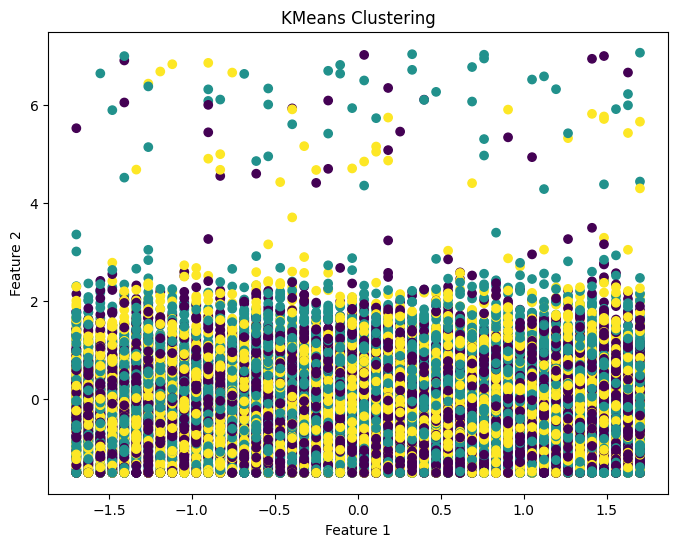

In [14]:
print("\n=== Clustering ===\n")

num_df = df.select_dtypes(include=np.number).dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_df)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
num_df["Cluster_KMeans"] = kmeans.fit_predict(scaled_data)

# Hierarchical Clustering
hier = AgglomerativeClustering(n_clusters=3)
num_df["Cluster_Hier"] = hier.fit_predict(scaled_data)

print("KMeans Cluster Counts:\n", num_df["Cluster_KMeans"].value_counts())
print("\nHierarchical Cluster Counts:\n", num_df["Cluster_Hier"].value_counts())

# Cluster Plot
plt.figure(figsize=(8,6))
plt.scatter(scaled_data[:,0], scaled_data[:,1], c=num_df["Cluster_KMeans"], cmap="viridis")
plt.title("KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


=== SECTION 2: CLUSTERING ANALYSIS ===
MiniBatchKMeans finished on sample size 2000
Cluster label counts: [379 506 557]


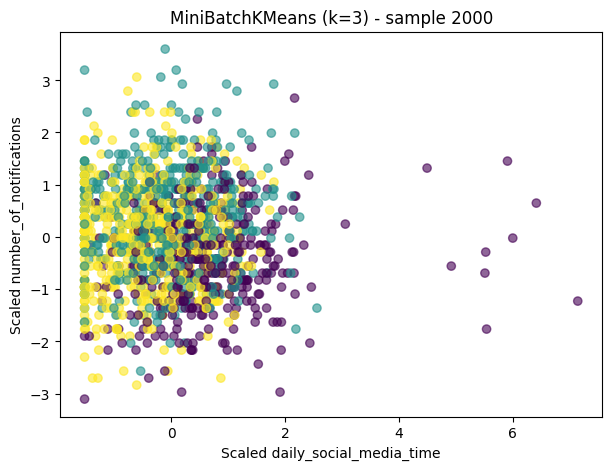

In [22]:
# ------------------ SECTION 2: CLUSTERING (fast) ------------------
print("\n=== SECTION 2: CLUSTERING ANALYSIS ===")
cluster_features = [
    'daily_social_media_time', 'number_of_notifications', 'work_hours_per_day',
    'sleep_hours', 'stress_level', 'actual_productivity_score'
]
cluster_features = [c for c in cluster_features if c in df.columns]
if len(cluster_features) < 2:
    print("Not enough numeric features for clustering. Found:", cluster_features)
else:
    # Subsample for speed
    sample_n = min(SAMPLED_CLUSTER_SIZE, len(df))
    sample_df = df.sample(n=sample_n, random_state=RANDOM_STATE).copy()  # avoid SettingWithCopyWarning

    # Drop rows with missing values in the selected cluster features
    sample_df.dropna(subset=cluster_features, inplace=True)

    X = sample_df[cluster_features].astype(float).values
    X_scaled = StandardScaler().fit_transform(X)

    # MiniBatchKMeans for speed on large data
    mbk = MiniBatchKMeans(
        n_clusters=K_CLUSTERS,
        batch_size=MBK_BATCH,
        random_state=RANDOM_STATE,
        n_init='auto'
    )
    klabels = mbk.fit_predict(X_scaled)

    print("MiniBatchKMeans finished on sample size", sample_n)
    print("Cluster label counts:", np.bincount(klabels))

    # Show scatter (first two cluster features)
    plt.figure(figsize=(7,5))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=klabels, alpha=0.6, cmap="viridis")
    plt.xlabel(f"Scaled {cluster_features[0]}")
    plt.ylabel(f"Scaled {cluster_features[1]}")
    plt.title(f"MiniBatchKMeans (k={K_CLUSTERS}) - sample {sample_n}")
    plt.show()


In [23]:
# ------------------ SECTION 3: COGNITIVE ANALYTICS & LOGISTIC REGRESSION ------------------
print("\n=== SECTION 3: COGNITIVE ANALYTICS & LOGISTIC REGRESSION ===")

# Create binary target variable 'high_productivity'
# Assuming 'high_productivity' is defined as actual_productivity_score above median
if 'actual_productivity_score' in df.columns:
    median_prod = df['actual_productivity_score'].median()
    df_model = df.copy()
    df_model['high_productivity'] = (df_model['actual_productivity_score'] > median_prod).astype(int)
else:
    print("Skipping logistic regression: 'actual_productivity_score' column not present.")
    df_model = df.copy() # Still create df_model for dummification even if regression is skipped


# Baseline predictors we like to include (only keep if present)
base_predictors = ['age', 'daily_social_media_time', 'sleep_hours', 'work_hours_per_day', 'stress_level', 'number_of_notifications']
predictors = [p for p in base_predictors if p in df_model.columns]

# Dummify gender and job_type but limit number of job_type dummies to 8 (avoid blow-up)
if 'gender' in df_model.columns:
    d_g = pd.get_dummies(df_model['gender'].astype(str), prefix='gender', drop_first=True)
    if not d_g.empty:
        df_model = pd.concat([df_model, d_g], axis=1)
        predictors += list(d_g.columns)

if 'job_type' in df_model.columns:
    d_j = pd.get_dummies(df_model['job_type'].astype(str), prefix='job', drop_first=True)
    if not d_j.empty:
        d_j = d_j.iloc[:, :8]  # keep top 8 new columns if many job types
        df_model = pd.concat([df_model, d_j], axis=1)
        predictors += list(d_j.columns)

# Ensure predictors exist and drop any rows with missing predictor/target (should be minimal after impute)
predictors = [p for p in predictors if p in df_model.columns]

if 'high_productivity' in df_model.columns:
    model_df = df_model[predictors + ['high_productivity']].dropna()

    if len(np.unique(model_df['high_productivity'])) < 2:
        print("Target 'high_productivity' has only one class after preprocessing. Cannot train logistic regression.")
    else:
        X = model_df[predictors].values
        y = model_df['high_productivity'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
        lr = LogisticRegression(max_iter=500)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        y_prob = lr.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_prob)

        print(f"\nLogistic Regression performance (predicting high_productivity):")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, ROC-AUC: {roc_auc:.4f}")
        print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

        # Save ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        fig, ax = plt.subplots(figsize=(6,5))
        ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        ax.plot([0,1],[0,1], linestyle='--', color='gray')
        ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate'); ax.set_title('ROC Curve (Logistic Regression)')
        ax.legend()
        roc_path = os.path.join(OUT_DIR, "logreg_roc_curve.png")
        fig.savefig(roc_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print("Saved ROC curve to:", roc_path)

        # Coefficients & odds ratios
        coef_df = pd.DataFrame({'feature': predictors, 'coef': lr.coef_.flatten()})
        coef_df['odds_ratio'] = np.exp(coef_df['coef'])
        coef_df = coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index)
        coef_out = "logreg_coefficients.csv"
        coef_df.to_csv(coef_out, index=False)
        print("Saved logistic regression coefficients and odds ratios to:", coef_out)
        print("\nTop coefficients (by absolute value):")
        display(coef_df.head(12))

else:
    print("Logistic regression skipped due to missing 'actual_productivity_score' column.")


=== SECTION 3: COGNITIVE ANALYTICS & LOGISTIC REGRESSION ===

Logistic Regression performance (predicting high_productivity):
Accuracy: 0.5397, Precision: 0.3333, Recall: 0.0019, ROC-AUC: 0.5136

Classification report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70      3149
           1       0.33      0.00      0.00      2676

    accuracy                           0.54      5825
   macro avg       0.44      0.50      0.35      5825
weighted avg       0.45      0.54      0.38      5825

Confusion matrix:
 [[3139   10]
 [2671    5]]
Saved ROC curve to: plots/logreg_roc_curve.png
Saved logistic regression coefficients and odds ratios to: logreg_coefficients.csv

Top coefficients (by absolute value):


feature      coef  odds_ratio
7              gender_Other -0.141227    0.868292
12           job_Unemployed  0.117631    1.124829
10                   job_IT  0.081521    1.084936
8               job_Finance  0.033618    1.034189
6               gender_Male -0.031508    0.968983
9                job_Health  0.019491    1.019682
2               sleep_hours -0.013534    0.986558
3        work_hours_per_day -0.012259    0.987816
11              job_Student  0.011650    1.011718
1   daily_social_media_time -0.007474    0.992553
4              stress_level  0.001646    1.001647
0                       age  0.000407    1.000407


=== Visualizations ===



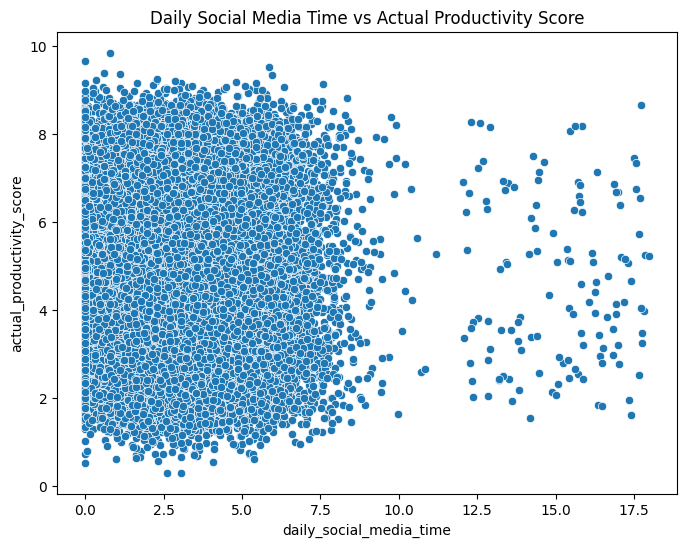

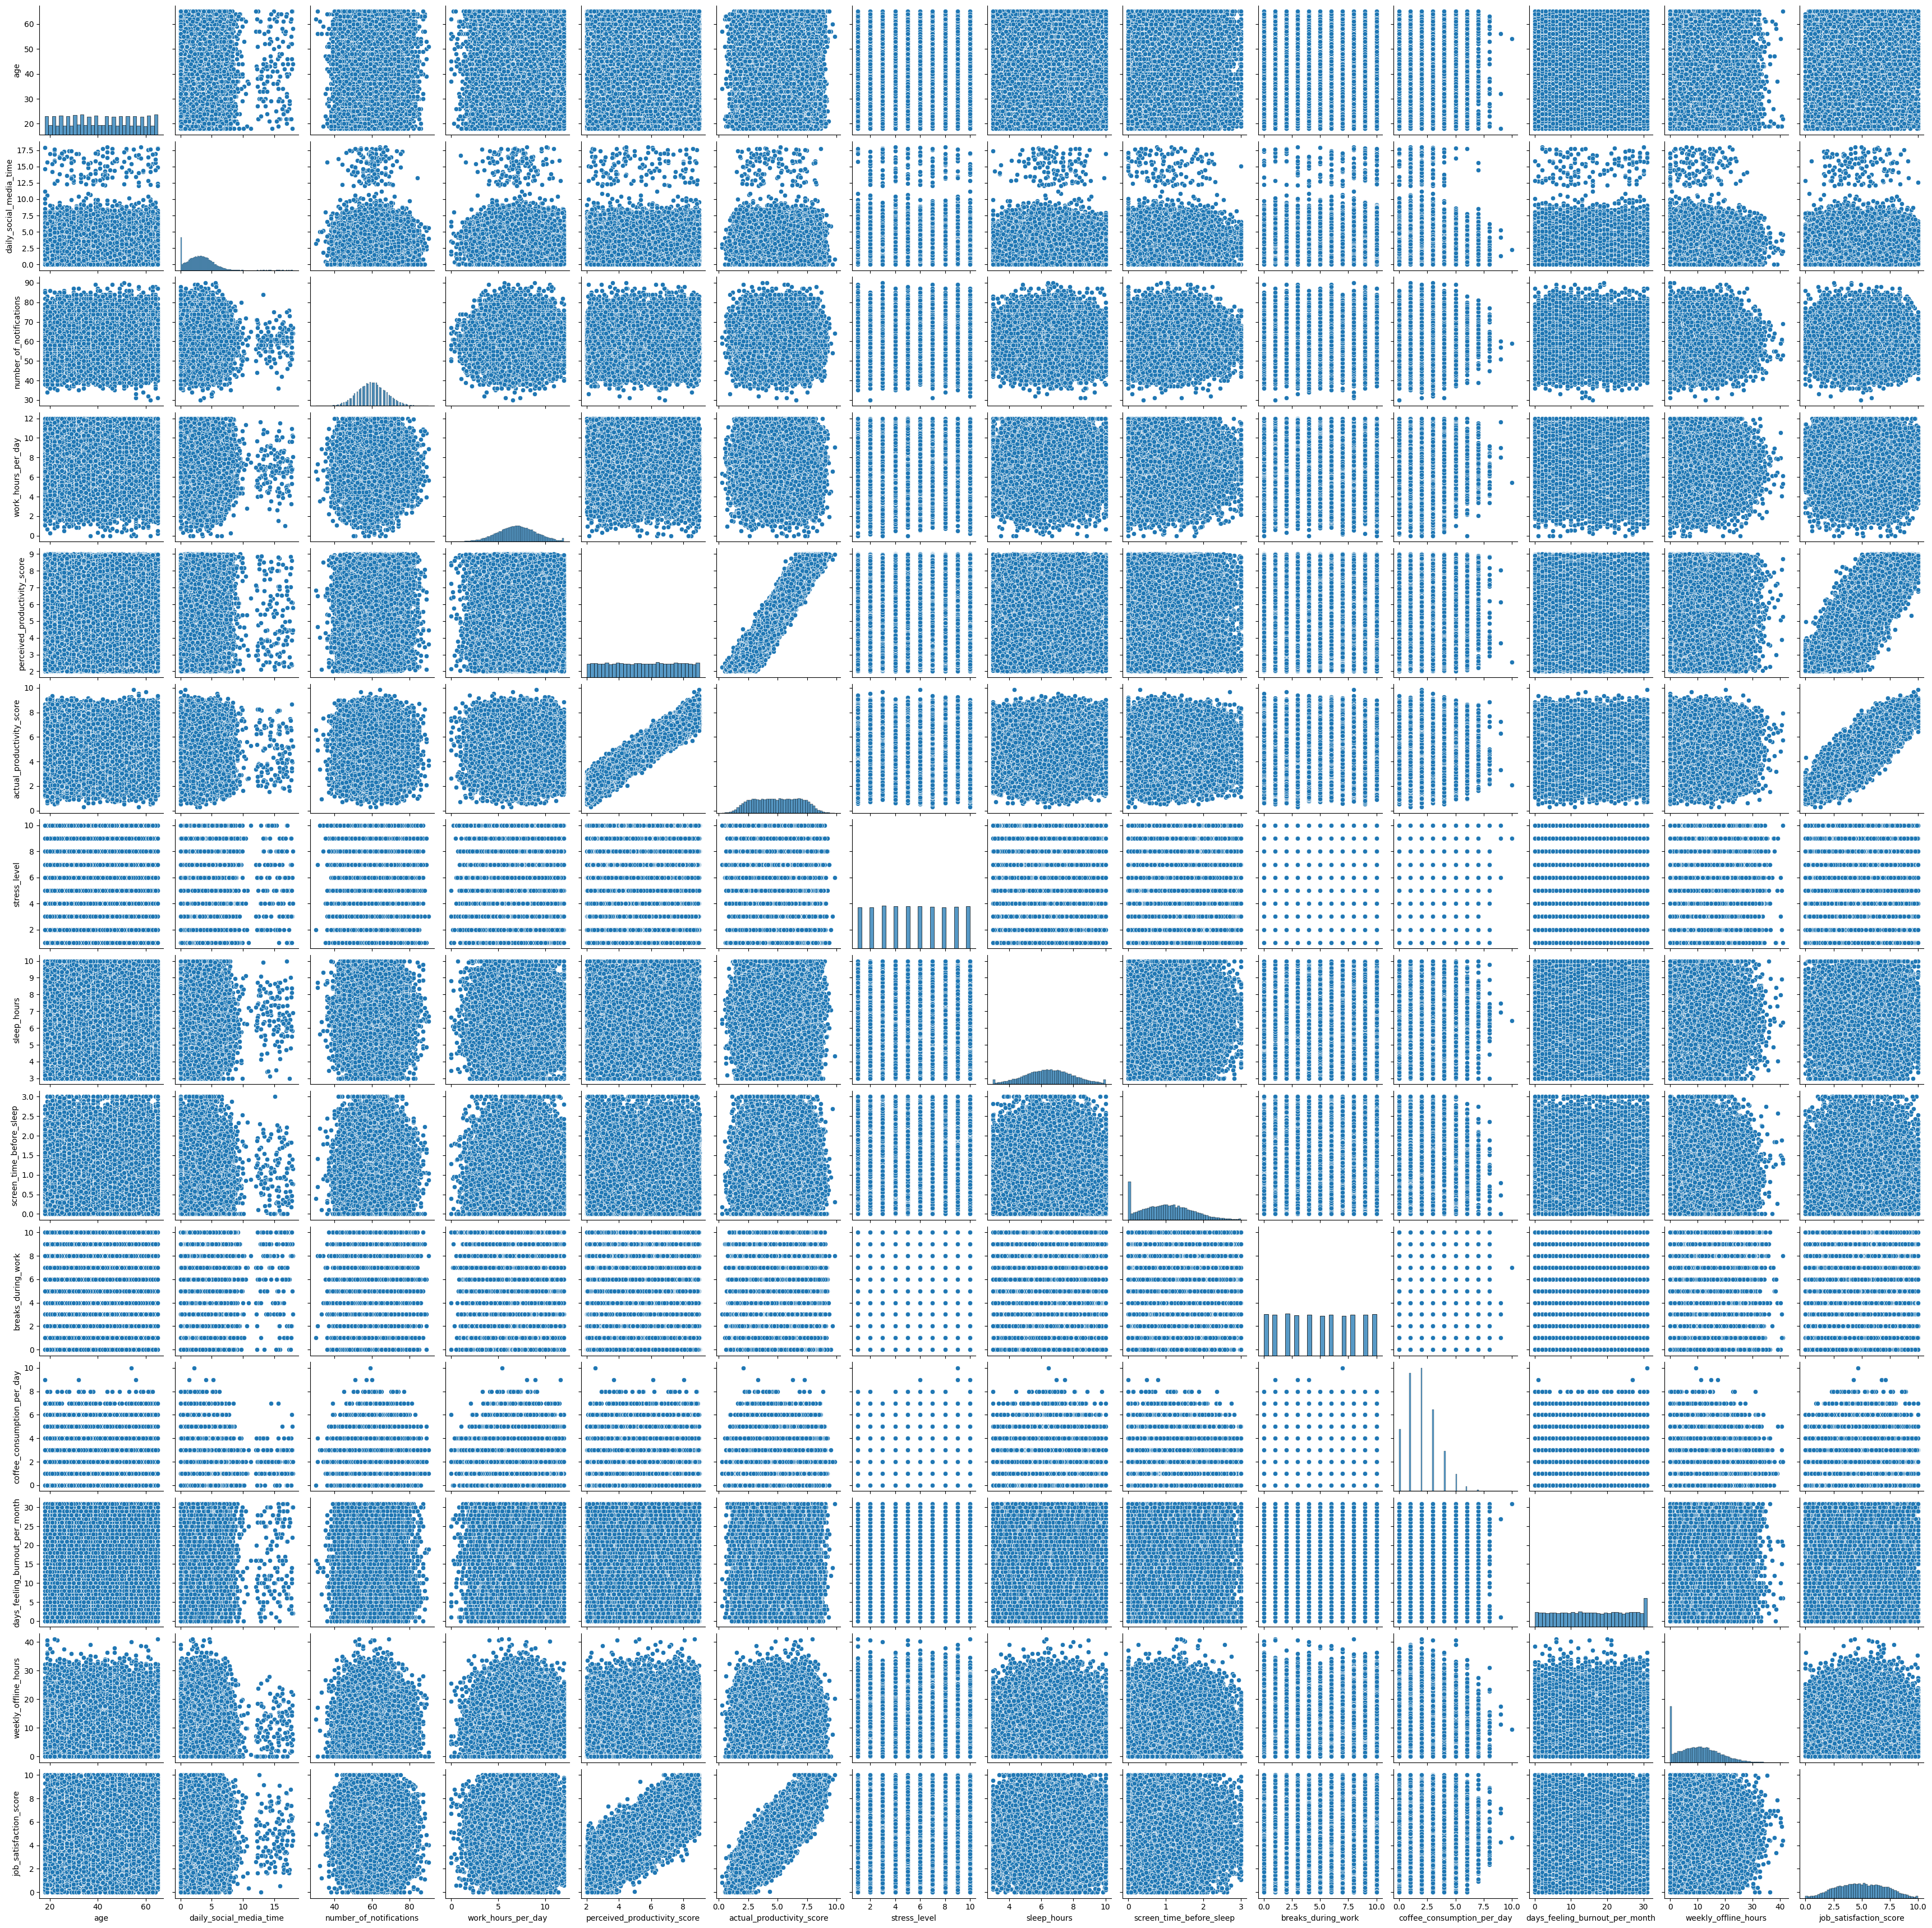

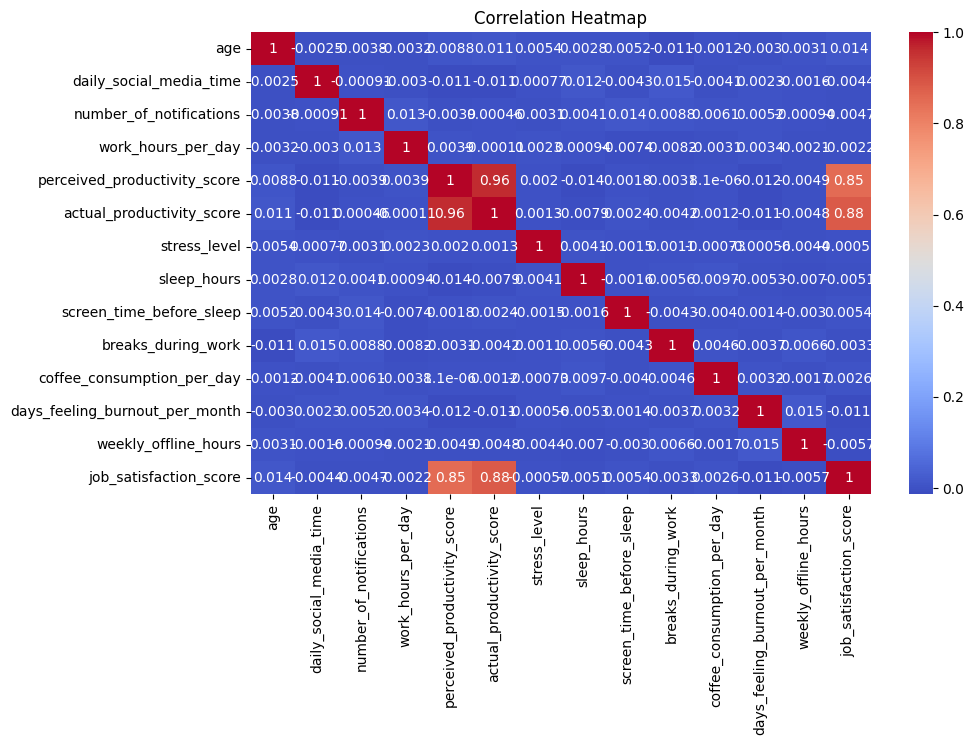

In [24]:
print("\n=== Visualizations ===\n")

if "daily_social_media_time" in df.columns and "actual_productivity_score" in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="daily_social_media_time", y="actual_productivity_score", data=df) # Removed hue="Cluster_KMeans" since num_df is used for clustering
    plt.title("Daily Social Media Time vs Actual Productivity Score")
    plt.show()

sns.pairplot(df.select_dtypes(include=np.number))
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

1. Summary of Findings with Charts

Boxplots showed the variation in productivity levels across different demographic groups (e.g., gender or age). The spread indicated that while most participants fall within a normal range, there are outliers who spend extreme amounts of time on social media, which correlates with lower productivity.

Scatter plots revealed a negative correlation between time spent on social media and productivity. As social media usage increased, productivity scores tended to decline. However, a few data points suggested balanced usage might not harm productivity significantly.

Cluster plots (from K-means and Hierarchical clustering) grouped students/professionals into 3 major clusters:

High social media – Low productivity

Moderate social media – Balanced productivity

Low social media – High productivity

These clusters visually highlighted behavioral patterns in the dataset.

2. Real-World Relationships and Applications

Education: Teachers and institutions can use these insights to raise awareness about the impact of excessive social media usage on students’ academic performance.

Workplace Productivity: Employers may design wellness programs or digital detox initiatives to encourage healthy usage of social media during working hours.

Healthcare and Psychology: Clustering insights can help psychologists understand digital behavior patterns and provide recommendations for reducing digital fatigue.

Policy Making: Governments and organizations could use such studies to set guidelines around screen-time, promoting digital well-being campaigns.

Overall Conclusion:
The analysis clearly supports the hypothesis that higher social media usage is generally associated with reduced productivity. However, moderate and mindful use may not negatively affect performance and can even provide social or creative benefits. The clustering results further validate that user behavior can be segmented into distinct groups, making it possible to tailor awareness programs and interventions more effectively.